# High-Dimensional sample-efficient Bayesian Optimization with SAASBO

## Imports & Setup

In [30]:
%reload_ext autoreload
%autoreload 2

from surrogate import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "figure.dpi": 400,
    "figure.figsize": (8, 4),
})
sns.set(style="whitegrid")

## Utilities

In [31]:
def plot_data(train_X, train_Y, test_X, test_Y):
    # Convert to NumPy arrays
    train_X_np = train_X.cpu().numpy()
    train_Y_np = train_Y.cpu().numpy()

    if test_X is not None and test_Y is not None:
        test_X_np = test_X.cpu().numpy()
        test_Y_np = test_Y.cpu().numpy()

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot train data
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=train_X_np[:, 0], y=train_Y_np[:, 0], label='Train Data', color='b')
    plt.title('Train Data')
    plt.xlabel('train_X')
    plt.ylabel('blackbox(train_X)')

    # Plot test data
    if test_X is not None and test_Y is not None:
        plt.subplot(1, 2, 2)
        sns.scatterplot(x=test_X_np[:, 0], y=test_Y_np[:, 0], label='Test Data', color='r')
        plt.title('Test Data')
        plt.xlabel('test_X')
        plt.ylabel('blackbox(test_X)')

    plt.tight_layout()
    plt.show()

In [32]:
def blackbox(x):
    x = -(x - 0.15)
    return torch.sin(x * (2 * torch.pi)) + torch.sin(x * (2 * torch.pi) * 2)

## Train

In [33]:
# Generate "true" data
true_x = torch.linspace(0, 1, 100).unsqueeze(-1)
true_y = blackbox(true_x)

# Generate initial training data point
train_x = torch.rand(15, 1)
train_y = blackbox(train_x)


gp_kwargs = {
    "n_posterior_samples": 1024,
    "x_bounds": None, # (min_x, max_x)
    "warmup_steps": 512,
    "num_samples": 256,
    "thinning": 32,
    "noise_scale": 1e-12,
    "jit_compile": True,
    "show_plot": True,
    "disable_progbar": False,
}

trainer = BayesianGPTrainer(train_x, train_y, true_x, **gp_kwargs)

In [34]:
trainer.train()

Sample: 100%|██████████████████████████████████████████| 768/768 [00:21, 35.74it/s, step size=6.42e-01, acc. prob=0.927]                                                                    


In [35]:
posterior = trainer.get_posterior()
samples = trainer.get_samples(posterior, 1000)

In [36]:
print(posterior.mean.squeeze(-1).T.shape)
print(posterior.variance.squeeze(-1).T.shape)
print(samples.shape)

torch.Size([100, 8])
torch.Size([100, 8])
torch.Size([100, 1])


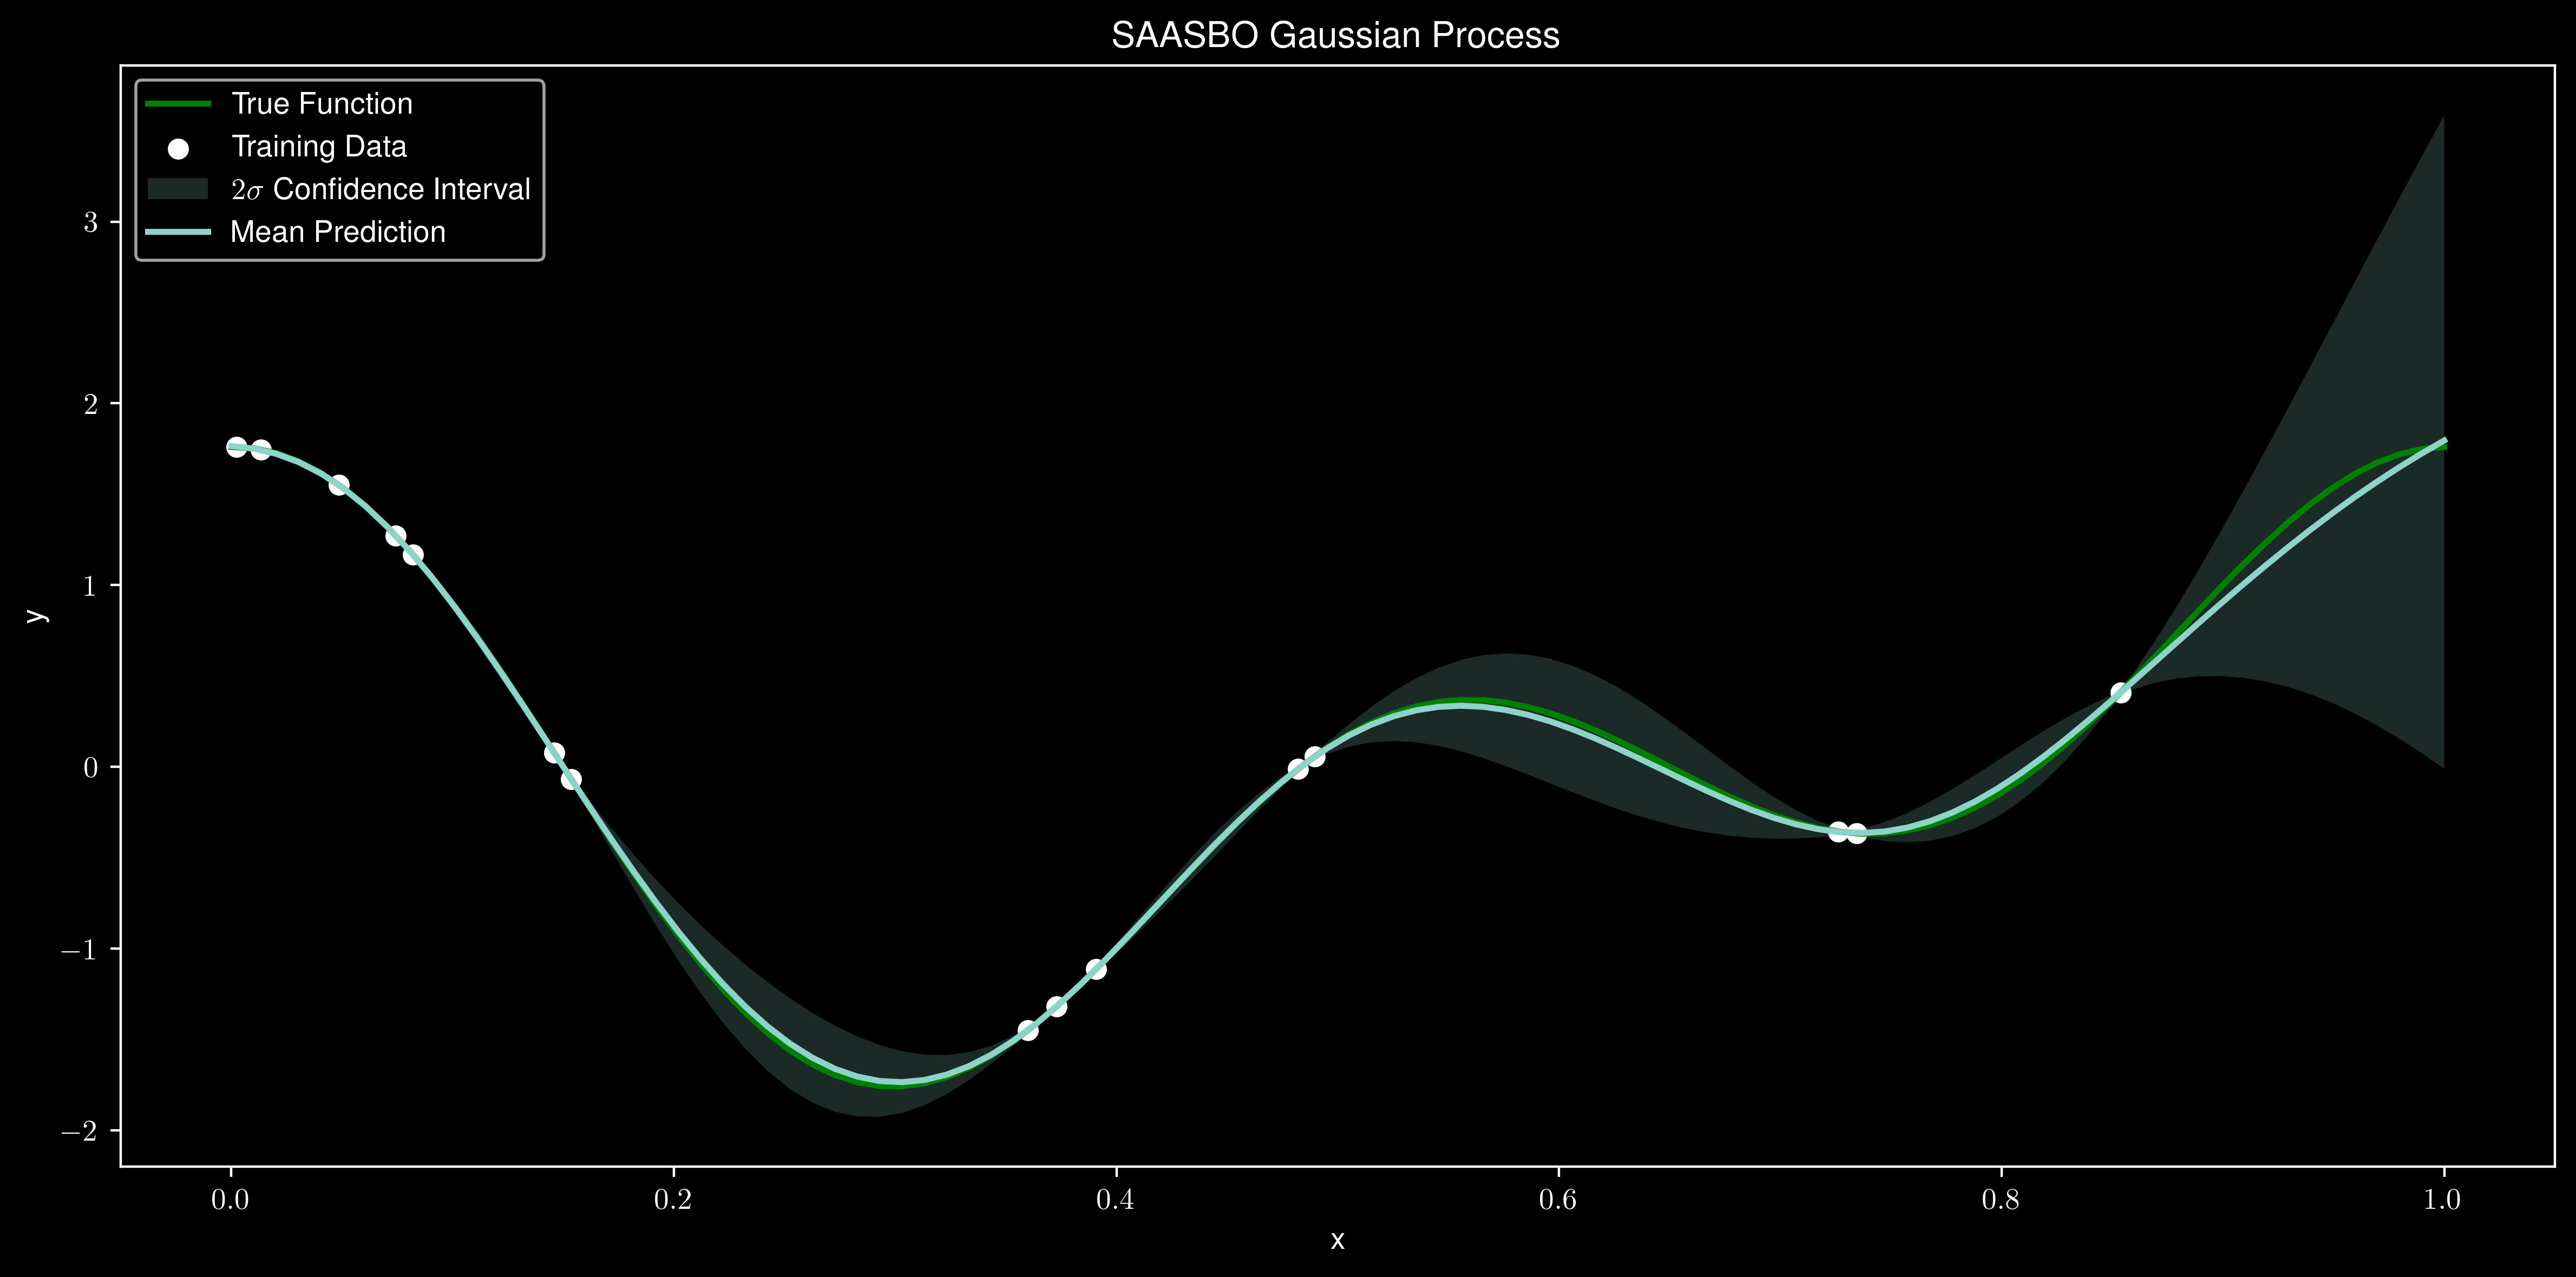

In [37]:
trainer.plot_gp(true_x, true_y, posterior, "./gp.png")